In [1]:
#Writing the import statements
import pandas as pd   
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import re
import json
import enchant
d = enchant.Dict("en_US")
from collections import Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
import numpy as np
#This is used for stemming of words
stemmer = PorterStemmer()


#import nltk
#nltk.download("stopwords")

from wordcloud import WordCloud, STOPWORDS

# Put the data into the prettytable

#pip install prettytable
from prettytable import PrettyTable
from collections import Counter


#pip install textblob
from textblob import TextBlob

#nltk.download('vader_lexicon')

import re

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from matplotlib import pyplot as plt

/home/abhishek/anaconda3/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [27]:
def readData():
    print("Gathering Raw Data")
    with open("review_partial.json",encoding="utf8") as f:
        reviews = f.read().strip().split("\n")
    reviews = [json.loads(review) for review in reviews]
    print("Gathered the Raw Data")
    return(reviews)

#Defining function for converting a raw review to a string of words 

def review_to_words(raw_review):
    # Function to convert a raw review to a string of words
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_review,"lxml").get_text() 
    #
    # 2. Remove non-letters
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    #
    #6.Remove Non-English words
    meaningful_words_2 = [w for w in meaningful_words if d.check(w)]
    #7.stemming
    #meaningful_words_3=[stemmer.stem(w) for w in  meaningful_words_2]
    # 8. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words_2))

# Read the data from disk and split into lines
# we use .strip() to remove the final (empty) line
    
def getTextsAndStars(reviews):
    print("Getting the Raw Text and the rating corresponding to the texts")
    texts = [review['text'] for review in reviews]
    stars = [review['stars'] for review in reviews]
    #Writing the texts and stars into a dataframe for later use
    textsAndStars = pd.DataFrame(columns=['texts','stars'])
    textsAndStars['texts'] = texts
    textsAndStars['stars'] = stars
    print("Obtained the raw text and ratings")
    texts = textsAndStars['texts']
    stars = textsAndStars['stars']
    return texts,stars


def getReviewsAndStarsForBusinesses(reviews,allTexts,allStars):
    #Getting all reviews for certain businesses
    texts = [review['text'] for review in reviews if review['business_id'] == "5LNZ67Yw9RD6nf4_UhXOjw"]
    #Getting all ratings for the user with most reviews
    stars = [review['stars'] for review in reviews if review['business_id'] == "5LNZ67Yw9RD6nf4_UhXOjw"]
    return texts,stars

#removing stopwords, special characters
def clean_Reviews(texts):
    print("Preparing to clean reviews")
    clean_reviews = []
    for i in range(len(texts)):
        clean_reviews.append( review_to_words( texts[i]))
    print("Cleaned all reviews")
    return(clean_reviews)

def getTopWordsForAllReviews(clean_reviews):
    word = []
    for text in clean_reviews:
        for w in text.split():
            word.append(w)
    filter_words = [word for word in word if word not in stopwords.words('english')]

    word_freq = Counter(filter_words)
    top_word = PrettyTable(field_names=['Word','Count']) # Header
    row_num = 0 # number of rows in table
    for item in word_freq.most_common()[:10]:
        top_word.add_row(item) # Adding rows
    top_word.align['Word'], top_word.align['Count'] = 'c', 'r' # Set column alignment
    print (top_word)
    return filter_words
    
def getPolarityOfAReview(review):

    # create TextBlob object of passed review text
    analysis = TextBlob(review)

    # set sentiment
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'
    
def getSentimentOfAReview(clean_reviews):
    reviewAndSentiment = pd.DataFrame(columns=['Review','Sentiment'])
    for i in range(len(clean_reviews)):
        sentiment = getPolarityOfAReview(clean_reviews[i])
        reviewAndSentiment = reviewAndSentiment.append({'Review':clean_reviews[i], 'Sentiment':sentiment}, ignore_index=True)
    return reviewAndSentiment


def getPositiveAndNegativeReviews(reviewAndSentiment):
    previews = [reviewAndSentiment['Review'][i] for i in range(len(reviewAndSentiment)) if reviewAndSentiment['Sentiment'][i] == 'positive']

    nreviews = [reviewAndSentiment['Review'][i] for i in range(len(reviewAndSentiment)) if reviewAndSentiment['Sentiment'][i] == 'negative']
    
    percentagePositiveReviews = 100*len(previews)/len(reviewAndSentiment)
    percentageNegativeReviews = 100*len(nreviews)/len(reviewAndSentiment)
    
    print("Percentage of positive reviews =",percentagePositiveReviews)
    print("Percentage of negative reviews =",percentageNegativeReviews)
    
    return previews, nreviews
#print(get_review_sentiment('today is not a good day'))    


def getWords(text):
    return re.compile('\w+').findall(text)


def getPositiveNegativeWordList(clean_reviews):
    sid = SentimentIntensityAnalyzer()
    pos_word_list=[]
    neu_word_list=[]
    neg_word_list=[]

    wordsFromReviews = []

    for i in range(len(clean_reviews)):
        wordsFromReviews.append(getWords(clean_reviews[i]))

    wordsFromReviews = list(set(wordsFromReviews[0]))

    for word in wordsFromReviews:
        if (sid.polarity_scores(word)['compound']) >= 0.3:
            pos_word_list.append(word)
        elif (sid.polarity_scores(word)['compound']) <= -0.1:
            neg_word_list.append(word)
        else:
            neu_word_list.append(word)                

    return pos_word_list, neu_word_list, neg_word_list


def wordcloud_draw(data, color = 'black'):
    #Doing an empty check on the list
    if data:
        wordcloud = WordCloud(stopwords=STOPWORDS,
                          background_color=color,
                          width=2500,
                          height=2000
                         ).generate(data)
        plt.figure(1,figsize=(13, 13))
        plt.imshow(wordcloud)
        plt.axis('off')
        plt.show()

In [25]:
businessIds = [review['business_id'] for review in reviews]

In [26]:
my_count = pd.Series(businessIds).value_counts()
a = list(my_count.index)
print(a[0:10])

['5LNZ67Yw9RD6nf4_UhXOjw', 'P7pxQFqr7yBKMMI2J51udw', 'frCxZS7lPhEnQRJ3UY6m7A', 'JAmQCmczUclNUfZjkNdjQA', '4GXII-GU7S0ZyU6ElkhscQ', 'J4CATH00YZrq8Bne2S4_cw', 'aLlREPOEtt3JzeDCagHytA', 'PgJgpW4TKQ8IoALH2Yq-zA', 'd4qwVw4PcN-_2mK2o1Ro1g', 'dKdApYVFDSNYsNOso6NYlA']


Gathering Raw Data
Gathered the Raw Data
Getting the Raw Text and the rating corresponding to the texts
Obtained the raw text and ratings
Preparing to clean reviews
Cleaned all reviews
+-------+-------+
|  Word | Count |
+-------+-------+
|  room |  5680 |
| hotel |  5096 |
|  one  |  2400 |
|  stay |  2196 |
| great |  2164 |
|  get  |  2015 |
| place |  1965 |
|  like |  1933 |
| rooms |  1742 |
|  time |  1737 |
+-------+-------+
Percentage of positive reviews = 90.9718387631143
Percentage of negative reviews = 8.337934842628382
Generating a word cloud for all the reviews


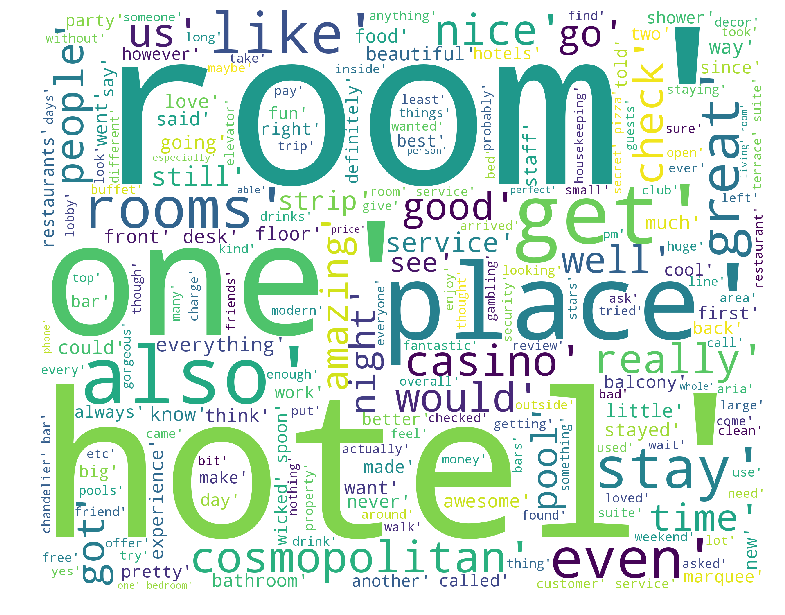

Generating the positive words' word cloud


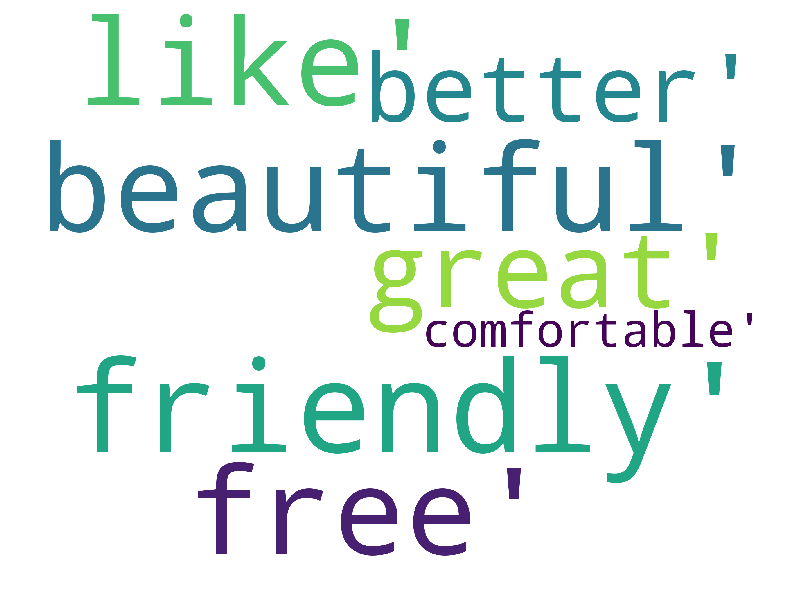

Generating the negative words' word cloud


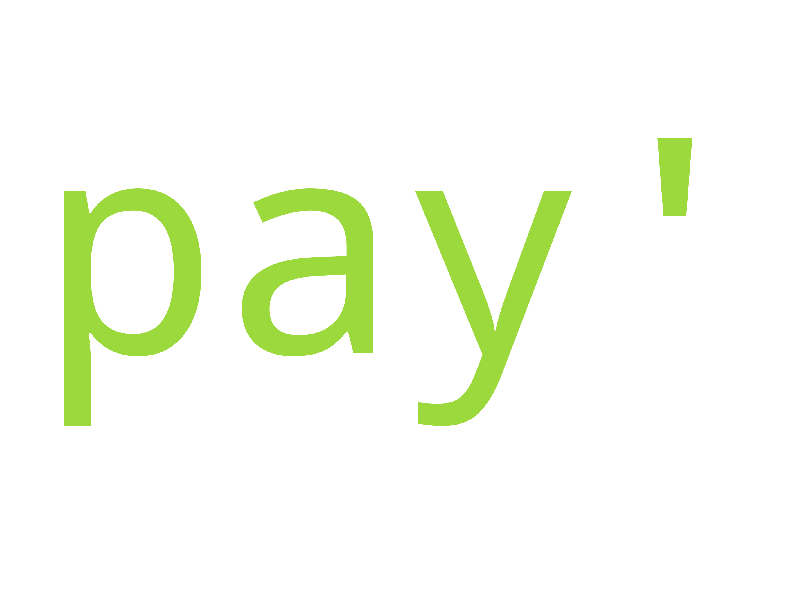

In [28]:
reviews = readData()
allTexts,allStars = getTextsAndStars(reviews)
clean_reviews = []
texts,stars = getReviewsAndStarsForBusinesses(reviews,allTexts,allStars)
clean_reviews = clean_Reviews(texts)
top_words = getTopWordsForAllReviews(clean_reviews)
reviewAndSentiment = getSentimentOfAReview(clean_reviews)
previews, nreviews = getPositiveAndNegativeReviews(reviewAndSentiment)
pos_word_list, neu_word_list, neg_word_list = getPositiveNegativeWordList(clean_reviews)
if len(top_words) != 0:
    print("Generating a word cloud for all the reviews")
    wordcloud_draw(str(top_words),'white')
if len(pos_word_list) != 0:
    print("Generating the positive words' word cloud")
    wordcloud_draw(str(pos_word_list),'white')
if len(neg_word_list) != 0:
    print("Generating the negative words' word cloud")
    wordcloud_draw(str(neg_word_list),'white')

In [32]:
reviews[4]

{'business_id': 'uYHaNptLzDLoV_JZ_MuzUA',
 'cool': 0,
 'date': '2013-11-20',
 'funny': 0,
 'review_id': 'DuffS87NaSMDmIfluvT83g',
 'stars': 5,
 'text': 'gute lage im stadtzentrum. shoppingmeile und sehenswürdigkeiten, sowie gute pubs in laufweite. das hotel ist neu, gut gepflegt und hat bemühtes/nettes personal. ideal für einen kurztrip nach edinburgh. längere aufenthalte eher nicht, da die zimmer recht klein sind.',
 'useful': 0,
 'user_id': '0xtbPEna2Kei11vsU-U2Mw'}

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

def create_Vectorizer():
    # Initialize the "CountVectorizer" object, which is scikit-learn's
    # bag of words tool.
    print ("Creating the bag of words...\n")

    vectorizer = CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None, stop_words = None, 
                                 max_features = 20000) 


    # fit_transform() does two functions: First, it fits the model
    # and learns the vocabulary; second, it transforms our training data
    # into feature vectors. The input to fit_transform should be a list of 
    # strings.
    data_features = vectorizer.fit_transform(clean_reviews)

    data_features = data_features.toarray()
    print("Created the bag of words")

    # Take a look at the words in the vocabulary
    vocab = vectorizer.get_feature_names()

    # # Sum up the counts of each vocabulary word
    dist = np.sum(data_features, axis=0)

    #The below code obtains the low frequency words
    threshold_count=2
    low_freq_words=[]
    
    # #for tag, count in zip(vocab, dist):
    low_freq_words=[tag  for tag, count in zip(vocab, dist) if(count<threshold_count)]
    
    return(data_features)

In [62]:
data_features = create_Vectorizer()

Creating the bag of words...

Created the bag of words


In [63]:
#Getting User ID for users

def getUsersAndCounts():
    print("Obtaining a collection of users and number of reviews in order to obtain top users")
    userIds = [review['user_id'] for review in reviews]
    from collections import Counter
    userCounts = Counter(userIds)
    #userCounts.most_common()

In [64]:
getUsersAndCounts()

Obtaining a collection of users and number of reviews in order to obtain top users


In [65]:
from sklearn.feature_extraction.text import TfidfVectorizer
def tfidf_vectorizer(): 
    print("Preparing to vectorize the text using tf-idf")
    # This vectorizer breaks text into single words and bi-grams and then calculates the TF-IDF representation
    vectorizer = TfidfVectorizer(ngram_range=(1,2))
    # the 'fit' builds up the vocabulary from all the reviews while the 'transform' step turns each indivdual text into
    # a matrix of numbers.
    vectors = vectorizer.fit_transform(clean_reviews)
    print("Completed tf-idf vectorization of text data")
    return(vectors)

In [66]:
vectors = tfidf_vectorizer()

Preparing to vectorize the text using tf-idf
Completed tf-idf vectorization of text data


In [67]:
#Cross Validation import
from sklearn.model_selection import cross_val_score

In [68]:
def gaussian_Naive_Bayes():    
    from sklearn.naive_bayes import GaussianNB
    clf = GaussianNB()
    print("Running Gaussian Naive Bayes")
    clf.fit(vectors.toarray(), stars)
    scores = cross_val_score(clf, vectors.toarray(), stars, cv=5)
    print("Getting Scores")
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [69]:
gaussian_Naive_Bayes()

Running Gaussian Naive Bayes
Getting Scores
[ 0.52301255  0.50420168  0.53164557  0.48945148  0.52765957]
Accuracy: 0.52 (+/- 0.03)


In [70]:
def linear_SVM():
    from sklearn.svm import LinearSVC
    classifier = LinearSVC()
    print("Running Linear SVM Classifier")
    classifier.fit(vectors.toarray(), stars)
    scores = cross_val_score(classifier, vectors.toarray(), stars, cv=5)
    print("Getting Scores")
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [71]:
linear_SVM()

Running Linear SVM Classifier
Getting Scores
[ 0.56903766  0.54621849  0.56118143  0.56118143  0.58297872]
Accuracy: 0.56 (+/- 0.02)


In [72]:
def support_Vector_Machine():
    from sklearn.svm import SVC
    classifierSVC = SVC(C=0.5,gamma=0.5)
    print("Running Support Vector Machine Classifier")
    classifierSVC.fit(vectors.toarray(), stars)
    scores = cross_val_score(classifierSVC, vectors.toarray(), stars, cv=5)
    print("Getting Scores")
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [ ]:
support_Vector_Machine()

Running Support Vector Machine Classifier


In [22]:
def random_Forest_Classifier():
    from sklearn.ensemble import RandomForestClassifier
    classifierRF = RandomForestClassifier()
    print("Running Random Forest Classifier")
    classifierRF.fit(vectors.toarray(), stars)
    scores = cross_val_score(classifierRF, vectors.toarray(), stars, cv=5)
    print("Getting Scores")
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [23]:
random_Forest_Classifier()

Getting Scores
[ 0.54637681  0.53913043  0.55152395  0.55167394  0.55393586]
Accuracy: 0.55 (+/- 0.01)


In [39]:
def tune_linear_svm():
    from sklearn.grid_search import GridSearchCV
    from sklearn.svm import LinearSVC
    print("Obtaining best hyper-parameters for Linear SVM Classifier")
    grid={"C": [0.05,0.5,1,1.5,2,5,10], "loss": ["hinge", "squared_hinge"], "class_weight": [None,"balanced"]}

    train_X = vectors.toarray()
    train_y = stars

    clf = GridSearchCV(LinearSVC(), grid, cv=3).fit(train_X, train_y)

    print(clf.best_params_)
    print(str(clf.best_score_))
    #print("")

    return clf

In [38]:
tune_linear_svm()

{'C': 2, 'class_weight': 'balanced', 'loss': 'squared_hinge'}
0.6202789076118536



GridSearchCV(cv=3, error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': [0.05, 0.5, 1, 1.5, 2, 5, 10], 'loss': ['hinge', 'squared_hinge'], 'class_weight': [None, 'balanced']},
       pre_dispatch='2*n_jobs', refit=True, scoring=None, verbose=0)

In [40]:
def logistic_Regression():
    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression() 
    model.fit(vectors.toarray(), stars)
    scores = cross_val_score(model, vectors.toarray(), stars, cv=5)
    print("Getting Scores")
    print(scores)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

In [41]:
logistic_Regression()

Getting Scores
[ 0.56811594  0.56376812  0.57329463  0.56914119  0.57725948]
Accuracy: 0.57 (+/- 0.01)


In [ ]:
reviews = readData()
textsAndStars = getTextsAndStars(reviews)